<a href="https://colab.research.google.com/github/armarmarm927/dl_lecture_competition_pub/blob/main/sparkproto12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine([-10,10],scale=(1,1.25)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [16]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [17]:
model_ft = models.resnet50(pretrained=True)
model_ft.fc = nn.Linear(model_ft.fc.in_features, 10)
net = model_ft.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [19]:
num_epochs = 50
loss_list = []
acc_list = []
train_acc_list = []

for epoch in range(num_epochs):
    net.train()
    correct_train = 0
    total_train = 0
    epoch_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = 100. * correct_train / total_train
    train_acc_list.append(train_accuracy)
    print(f'Epoch {epoch+1}: Loss: {epoch_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%')
    loss_list.append(epoch_loss/len(train_loader))

    net.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    test_accuracy = 100. * correct / total
    acc_list.append(test_accuracy)
    print(f'Test Accuracy: {test_accuracy:.2f}%')

    # 混同行列の出力
    cm = confusion_matrix(y_true, y_pred)
    print(f'Confusion Matrix (Epoch {epoch+1}):')
    print(cm)

    torch.save(net.state_dict(), '/content/drive/MyDrive/Weight_Epoch50.pth')
    scheduler.step()

Epoch 1: Loss: 0.9640, Train Accuracy: 67.02%
Test Accuracy: 75.38%
Confusion Matrix (Epoch 1):
[[781  10  18  26  21   7   8  21  76  32]
 [ 22 758   7  20   3  16   4   6  88  76]
 [ 72   0 578  30  99 128  58  23   7   5]
 [ 21   1  36 576  67 202  50  26  15   6]
 [ 17   1  39  32 752  22  77  48  11   1]
 [  7   0  11 124  65 747  13  27   5   1]
 [  1   3  25  61  17  39 848   0   6   0]
 [ 14   1  17  28  70  58   7 794   4   7]
 [ 61   7  11  14   7   6   0   4 873  17]
 [ 21  40   4  15   2  15   5  16  51 831]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2: Loss: 0.6989, Train Accuracy: 76.31%
Test Accuracy: 74.90%
Confusion Matrix (Epoch 2):
[[818  38  24  39   4  12   7   5  42  11]
 [  3 923   4   4   0  20   6   1  24  15]
 [ 53   4 754  40  34  74  28   4   7   2]
 [  7   5  78 514  11 336  34   6   6   3]
 [ 22   2 114  58 586 124  53  28  12   1]
 [  6   1  45  81  13 840   7   6   1   0]
 [  2   3  58  40   7  72 809   1   8   0]
 [ 18   4  52  29  22 179   5 679   5   7]
 [ 58  19  13  18   2  18   1   0 864   7]
 [ 20 173  12  14   0  43   6   4  25 703]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3: Loss: 0.6156, Train Accuracy: 79.34%
Test Accuracy: 78.28%
Confusion Matrix (Epoch 3):
[[853   7  20  33  12   4   1   9  52   9]
 [ 25 858   4  15   1   1   5   2  23  66]
 [ 73   0 687  48 111  24  20  21   9   7]
 [ 15   1  37 740  52  61  53  23  10   8]
 [ 12   2  18  76 798   7  19  59   5   4]
 [  9   2  36 225  39 600  34  49   2   4]
 [  7   5  37  55  49   6 820  12   7   2]
 [ 13   1   9  74  24  20   6 841   3   9]
 [ 89  21  11  28   7   8   2   8 816  10]
 [ 51  56  10  19   1   9   2   8  29 815]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4: Loss: 0.6922, Train Accuracy: 76.70%
Test Accuracy: 77.31%
Confusion Matrix (Epoch 4):
[[915   9   7   9   7   1   8  17  18   9]
 [ 44 840   0   8   2   5   4   8  26  63]
 [ 81   1 666  35 101  66  19  27   1   3]
 [ 23   5  29 597  61 182  39  51   6   7]
 [ 17   3  28  40 789  41   6  73   2   1]
 [ 10   1  15 111  31 771   7  52   0   2]
 [  9   5  41  54  84  28 762  11   2   4]
 [ 16   1   6  20  19  55   3 878   1   1]
 [189  19  20  15   8   9   1   7 711  21]
 [ 77  60   2   7   2  10   3  21  16 802]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5: Loss: 0.6332, Train Accuracy: 78.58%
Test Accuracy: 81.98%
Confusion Matrix (Epoch 5):
[[872  17  23   7   5   1   5   5  48  17]
 [ 10 947   3   2   0   0   2   4   3  29]
 [ 60   2 792  25  43  19  23  26   5   5]
 [ 22   5  65 589  51 146  58  51   6   7]
 [  5   3  54  14 830  12  23  52   7   0]
 [ 15   1  58  89  39 714  24  54   6   0]
 [  7   9  44  40  25   8 860   4   1   2]
 [ 14   2  18  18  18  23   8 894   3   2]
 [ 38  47  10   6   6   2   6   0 872  13]
 [ 28  97   7   7   0   1   0  13  19 828]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 6: Loss: 0.4999, Train Accuracy: 82.72%
Test Accuracy: 81.96%
Confusion Matrix (Epoch 6):
[[856  10  10  14   9   1   1   4  74  21]
 [  9 881   4   6   2   3   1   0  40  54]
 [ 70   3 738  41  51  46  18  15   8  10]
 [ 20   5  45 627  33 176  37  24  15  18]
 [ 16   1  50  27 803  21  10  56  10   6]
 [  8   1  22 108  35 773  10  34   5   4]
 [  6   5  33  44  25  22 843   4  11   7]
 [ 13   4   9  29  19  37   1 868   7  13]
 [ 32   8   5  10   4   0   2   1 919  19]
 [ 29  39   7   4   2   2   1   2  26 888]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 7: Loss: 0.4580, Train Accuracy: 84.06%
Test Accuracy: 82.73%
Confusion Matrix (Epoch 7):
[[917   6  22   9   0   0   0   4  34   8]
 [ 17 909   2   6   1   3   5   3  17  37]
 [ 40   1 876  12  24  20   6  10   7   4]
 [ 29   4  84 682  23 128  24  14   8   4]
 [ 36   1 100  49 717  24  20  39  12   2]
 [ 16   2  51 112  19 758  14  25   0   3]
 [ 11   4  94  50  14  10 808   1   6   2]
 [ 19   1  22  53  19  28   2 848   1   7]
 [ 57  21   7   8   1   2   1   1 897   5]
 [ 46  59   8   8   0   2   2   1  13 861]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 8: Loss: 0.4266, Train Accuracy: 85.21%
Test Accuracy: 83.26%
Confusion Matrix (Epoch 8):
[[861  14  41   7   4   0   6  13  35  19]
 [  8 936   5   7   2   2   5   2   5  28]
 [ 34   1 834  22  41  31  24  11   1   1]
 [ 23   3  65 618  26 169  58  27   8   3]
 [  8   1  51  37 809  44  18  27   3   2]
 [ 12   3  42 105  22 776  13  23   4   0]
 [  3   3  27  24  15  29 892   5   0   2]
 [ 12   1  24  16  21  44   5 873   3   1]
 [ 40  30  15   8   4   2   2   4 883  12]
 [ 31  63   6  10   3   6   7  13  17 844]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 9: Loss: 0.3984, Train Accuracy: 86.19%
Test Accuracy: 83.93%
Confusion Matrix (Epoch 9):
[[846  21  16   7   6   4   3   9  60  28]
 [  3 950   4   2   3   2   1   1   8  26]
 [ 58   3 779  25  48  25  32  15   5  10]
 [ 13   4  40 617  32 178  43  44   9  20]
 [  5   1  24  30 792  37  36  60  11   4]
 [  9   1  22  89  18 795  20  37   2   7]
 [  7   4  21  26   8  17 902  11   1   3]
 [  9   4   9  13  15  24   4 909   5   8]
 [ 25  30   6   4   3   2   0   1 905  24]
 [ 15  61   5   5   0   1   1   1  13 898]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 10: Loss: 0.3799, Train Accuracy: 86.86%
Test Accuracy: 83.76%
Confusion Matrix (Epoch 10):
[[859   6  45   7   8   1   3  10  50  11]
 [ 11 890   5   6   1   1   1   7  19  59]
 [ 31   3 793  45  50  24  20  28   1   5]
 [ 21   1  38 672  28 155  33  34   5  13]
 [  9   3  25  26 790  39  22  76   7   3]
 [ 15   2  25  92  23 782  20  38   1   2]
 [  7   4  29  50  19  17 857  12   1   4]
 [  8   3   7  16  10  38   4 910   1   3]
 [ 27   9  16  10   7   1   1   2 914  13]
 [ 24  36   3   3   1   2   1   7  14 909]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 11: Loss: 0.2691, Train Accuracy: 90.83%
Test Accuracy: 86.90%
Confusion Matrix (Epoch 11):
[[892   8  26   6   6   2   5   4  32  19]
 [  5 931   5   4   3   1   0   1  13  37]
 [ 30   2 838  20  45  18  28  11   4   4]
 [ 11   3  42 731  26 120  34  14   8  11]
 [  5   1  31  24 864  23  20  24   5   3]
 [ 10   1  24 113  26 793  16  14   3   0]
 [  5   2  21  26  12  13 914   4   1   2]
 [  8   2  13  29  23  34   3 883   1   4]
 [ 23  11   8  10   6   1   1   2 925  13]
 [ 15  37   4   3   1   2   0   3  16 919]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 12: Loss: 0.2226, Train Accuracy: 92.30%
Test Accuracy: 87.03%
Confusion Matrix (Epoch 12):
[[899   6  24   8   4   1   4   3  35  16]
 [  4 933   4   4   1   1   0   3  16  34]
 [ 34   0 849  24  33  17  25  13   3   2]
 [ 10   4  48 768  18  90  28  16   8  10]
 [  5   1  36  30 847  25  19  29   3   5]
 [  8   2  31 141  19 771  13  10   4   1]
 [  7   3  27  29  11  10 905   3   2   3]
 [  8   3  13  33  19  31   3 888   0   2]
 [ 28   7   9   7   5   1   1   2 928  12]
 [ 21  36   2   5   0   1   1   3  16 915]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 13: Loss: 0.2018, Train Accuracy: 93.06%
Test Accuracy: 87.41%
Confusion Matrix (Epoch 13):
[[921   7  22   3   5   3   4   1  24  10]
 [  8 937   3   5   0   1   1   2  11  32]
 [ 32   0 853  16  40  16  27  12   2   2]
 [ 15   3  46 718  26 119  35  21   8   9]
 [  5   1  34  19 870  21  21  23   3   3]
 [  9   3  35 104  30 788  15  12   4   0]
 [  5   1  20  22  13  12 919   4   2   2]
 [  9   2  10  15  24  29   3 903   2   3]
 [ 26  13   8   9   6   1   1   2 921  13]
 [ 20  44   2   3   0   2   1   5  12 911]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 14: Loss: 0.1839, Train Accuracy: 93.65%
Test Accuracy: 87.14%
Confusion Matrix (Epoch 14):
[[916   6  16   6   5   1   5   2  33  10]
 [  5 932   5   5   0   1   0   1  19  32]
 [ 39   0 838  32  33  15  24  14   4   1]
 [ 10   4  33 754  24 114  28  13  12   8]
 [  4   1  33  29 852  22  17  35   3   4]
 [  9   3  25 126  20 784  14  14   4   1]
 [  6   3  22  34  11  13 902   3   4   2]
 [  6   4   9  31  19  28   4 894   4   1]
 [ 24   6   2   9   6   1   0   1 941  10]
 [ 23  43   2   4   0   2   1   3  21 901]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 15: Loss: 0.1732, Train Accuracy: 93.90%
Test Accuracy: 86.76%
Confusion Matrix (Epoch 15):
[[903   7  27   8   6   2   7   3  28   9]
 [  8 940   1   3   0   1   0   2  14  31]
 [ 35   0 834  28  41  15  26  15   3   3]
 [ 13   4  37 738  26 111  35  20  10   6]
 [  4   2  31  31 851  23  19  36   2   1]
 [  8   2  28 121  27 779  14  19   2   0]
 [  6   3  23  34  14  13 900   4   2   1]
 [  7   3  12  20  18  29   2 906   2   1]
 [ 27   8   5  10   5   0   0   2 932  11]
 [ 24  45   3   8   1   2   1   5  18 893]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 16: Loss: 0.1647, Train Accuracy: 94.23%
Test Accuracy: 87.26%
Confusion Matrix (Epoch 16):
[[910   8  21   7   4   3   5   2  28  12]
 [  4 941   4   5   1   1   0   1  15  28]
 [ 37   0 850  22  35  18  22  13   2   1]
 [ 11   4  39 750  27 118  27  11   8   5]
 [  5   2  32  23 866  29  14  24   2   3]
 [ 11   2  23 123  17 802  13   6   2   1]
 [  5   3  24  34  15  19 893   4   1   2]
 [ 10   3  12  27  23  42   3 877   2   1]
 [ 24   9   4  14   4   1   0   2 932  10]
 [ 19  41   2   5   0   2   1   5  20 905]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 17: Loss: 0.1501, Train Accuracy: 94.69%
Test Accuracy: 87.42%
Confusion Matrix (Epoch 17):
[[918   7  24   5   4   2   3   3  27   7]
 [ 10 927   6   4   0   2   0   2  17  32]
 [ 32   0 858  20  36  14  22  12   2   4]
 [  9   3  36 751  26 112  29  13  10  11]
 [  3   1  34  26 852  25  17  35   4   3]
 [ 10   1  25 120  23 799  10   9   2   1]
 [  5   2  26  28  11  13 907   5   1   2]
 [  8   3  12  26  21  33   2 894   0   1]
 [ 28  10   6  11   5   1   0   2 924  13]
 [ 21  39   1   5   0   2   1   3  16 912]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 18: Loss: 0.1425, Train Accuracy: 95.15%
Test Accuracy: 87.31%
Confusion Matrix (Epoch 18):
[[895   8  27   8   4   3   6   4  30  15]
 [  6 937   5   5   0   2   0   2  14  29]
 [ 30   1 857  24  33  16  22  13   1   3]
 [ 12   3  39 734  34 121  34   9   8   6]
 [  3   1  31  23 874  19  20  25   3   1]
 [  8   1  28 110  21 804  15  10   2   1]
 [  6   2  24  31  10  13 908   3   1   2]
 [ 11   2  11  22  23  35   3 891   0   2]
 [ 28  12   9  10   6   0   0   2 919  14]
 [ 19  42   2   6   1   1   0   3  14 912]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 19: Loss: 0.1263, Train Accuracy: 95.55%
Test Accuracy: 87.49%
Confusion Matrix (Epoch 19):
[[916   8  22   6   4   3   5   2  26   8]
 [  9 943   3   3   1   2   1   1   9  28]
 [ 30   1 862  24  37  14  17  11   2   2]
 [ 13   5  41 749  27 109  27  12   9   8]
 [  4   1  29  24 870  25  14  29   2   2]
 [ 10   2  27 119  25 794  14   7   2   0]
 [  4   4  32  27  17  15 893   6   1   1]
 [  6   2  10  22  22  36   4 895   1   2]
 [ 35  12   6   8   6   0   0   2 918  13]
 [ 23  39   2   5   1   2   0   2  17 909]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 20: Loss: 0.1266, Train Accuracy: 95.58%
Test Accuracy: 87.27%
Confusion Matrix (Epoch 20):
[[911   6  25   6   4   2   2   4  31   9]
 [  6 925   4   5   2   2   1   3  15  37]
 [ 26   1 855  24  40  15  24  10   2   3]
 [ 12   5  32 737  33 128  23  12  13   5]
 [  2   1  32  32 865  27  14  23   3   1]
 [  8   2  26 114  25 805  10   7   3   0]
 [  4   2  23  36  17  12 901   3   1   1]
 [  9   3   8  24  21  41   5 888   0   1]
 [ 30  10   7   9   5   0   1   2 923  13]
 [ 22  30   2   5   1   2   0   4  17 917]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 21: Loss: 0.1082, Train Accuracy: 96.30%
Test Accuracy: 87.40%
Confusion Matrix (Epoch 21):
[[915   7  25   4   4   3   3   4  29   6]
 [  6 938   3   3   2   2   0   3  14  29]
 [ 27   0 867  22  32  14  20  12   2   4]
 [ 12   6  36 742  32 116  25  14  13   4]
 [  3   1  35  30 857  25  14  29   3   3]
 [  8   2  28 119  25 791  11  14   2   0]
 [  4   2  27  34  14  13 901   3   1   1]
 [  8   4   9  21  20  37   4 896   1   0]
 [ 31  12   7   9   5   0   1   2 923  10]
 [ 21  38   2   5   1   2   0   4  17 910]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 22: Loss: 0.1025, Train Accuracy: 96.46%
Test Accuracy: 87.38%
Confusion Matrix (Epoch 22):
[[913   8  23   6   4   2   2   3  29  10]
 [  7 940   1   3   1   1   0   2  14  31]
 [ 32   2 855  27  31  15  22  12   2   2]
 [ 12   6  34 756  30 111  25   8  13   5]
 [  4   1  34  34 854  24  13  30   3   3]
 [  8   2  26 124  25 792  11   9   3   0]
 [  6   2  25  38  13  12 899   3   1   1]
 [  9   4  10  26  20  35   4 890   1   1]
 [ 31  12   5  11   4   0   1   2 923  11]
 [ 20  37   2   5   1   1   0   2  16 916]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 23: Loss: 0.0996, Train Accuracy: 96.61%
Test Accuracy: 87.47%
Confusion Matrix (Epoch 23):
[[906   7  28   5   4   3   4   3  29  11]
 [  6 936   2   5   1   2   1   1  14  32]
 [ 27   1 862  21  32  15  25  12   2   3]
 [ 12   6  35 757  31 104  29   9  13   4]
 [  3   1  32  31 858  26  14  29   3   3]
 [  8   2  27 121  25 791  13  12   1   0]
 [  5   2  20  36  13  10 909   3   1   1]
 [  8   4  11  23  21  35   4 893   0   1]
 [ 30  14   6  11   5   0   1   2 920  11]
 [ 20  37   2   5   1   2   0   2  16 915]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 24: Loss: 0.0994, Train Accuracy: 96.57%
Test Accuracy: 87.48%
Confusion Matrix (Epoch 24):
[[922   7  18   5   4   3   3   3  26   9]
 [  7 935   2   5   1   1   1   3  14  31]
 [ 33   1 851  23  33  17  25  12   2   3]
 [ 13   4  35 758  30 104  28  10  13   5]
 [  4   1  30  34 854  26  15  31   2   3]
 [  8   2  25 126  22 786  13  16   2   0]
 [  5   2  22  38  10  10 908   3   1   1]
 [  8   3   9  23  20  33   4 898   1   1]
 [ 35  12   5  10   4   0   0   2 920  12]
 [ 20  35   2   5   1   2   0   2  17 916]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 25: Loss: 0.0962, Train Accuracy: 96.66%
Test Accuracy: 87.56%
Confusion Matrix (Epoch 25):
[[908   8  24   6   4   3   5   3  31   8]
 [  6 942   2   5   0   1   1   1  14  28]
 [ 28   2 855  26  33  13  27  12   2   2]
 [ 12   6  35 763  31  97  29   9  13   5]
 [  4   1  30  32 858  23  16  30   3   3]
 [  8   2  27 126  25 782  14  13   2   1]
 [  5   2  21  31  10  10 916   3   1   1]
 [  8   4  10  24  20  32   4 897   1   0]
 [ 32  12   5   9   4   0   0   1 929   8]
 [ 20  41   2   5   1   1   0   2  22 906]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 26: Loss: 0.0950, Train Accuracy: 96.63%
Test Accuracy: 87.36%
Confusion Matrix (Epoch 26):
[[910   7  26   5   4   3   5   4  27   9]
 [  7 939   3   4   2   1   0   4  13  27]
 [ 27   1 862  26  32  13  23  13   1   2]
 [ 13   4  36 753  31 112  27  10  10   4]
 [  3   1  30  31 863  26  14  29   2   1]
 [  8   2  25 124  24 791  13  12   1   0]
 [  5   2  25  32  13  12 905   4   1   1]
 [  8   2  11  23  19  40   4 892   0   1]
 [ 33  13   7  14   5   0   0   2 915  11]
 [ 23  40   2   5   1   2   0   5  16 906]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 27: Loss: 0.0924, Train Accuracy: 96.79%
Test Accuracy: 87.60%
Confusion Matrix (Epoch 27):
[[916   8  24   4   4   3   3   3  26   9]
 [  5 943   2   5   0   1   0   2  13  29]
 [ 29   1 868  25  28  13  20  12   1   3]
 [ 12   6  35 758  28 105  28  11  12   5]
 [  4   1  33  34 848  25  16  33   3   3]
 [  8   2  26 119  22 792  14  15   2   0]
 [  5   2  28  34  12  10 902   4   1   2]
 [  8   3   9  22  18  34   4 901   0   1]
 [ 36  15   5   9   4   0   0   1 917  13]
 [ 19  42   2   4   1   1   0   3  13 915]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 28: Loss: 0.0922, Train Accuracy: 96.83%
Test Accuracy: 87.64%
Confusion Matrix (Epoch 28):
[[909   7  20   7   4   3   5   3  31  11]
 [  7 935   2   5   1   1   0   2  15  32]
 [ 31   1 851  29  34  14  24  12   2   2]
 [ 12   4  31 765  30 106  24  10  12   6]
 [  4   1  29  32 864  22  14  28   3   3]
 [  8   1  22 122  23 796  14  13   1   0]
 [  5   2  22  35  11  11 908   4   1   1]
 [  7   3   9  24  21  38   4 893   0   1]
 [ 29  10   5  12   4   0   0   1 928  11]
 [ 22  34   2   5   1   1   0   3  17 915]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 29: Loss: 0.0900, Train Accuracy: 96.86%
Test Accuracy: 87.46%
Confusion Matrix (Epoch 29):
[[904   8  27   6   5   3   6   3  28  10]
 [  5 940   2   6   0   1   0   3  13  30]
 [ 25   2 861  25  33  15  21  14   1   3]
 [ 12   4  33 752  29 114  26  12  13   5]
 [  4   1  30  31 857  25  15  31   3   3]
 [  8   2  24 120  23 794  13  14   2   0]
 [  5   2  25  34  11  13 904   4   1   1]
 [  7   2   9  21  20  40   4 896   0   1]
 [ 29  15   5  10   5   0   0   2 924  10]
 [ 20  38   2   5   1   2   0   4  14 914]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 30: Loss: 0.0895, Train Accuracy: 96.92%
Test Accuracy: 87.52%
Confusion Matrix (Epoch 30):
[[907   7  24   5   5   3   5   3  32   9]
 [  7 941   2   5   1   1   0   2  14  27]
 [ 30   1 852  23  37  17  24  13   1   2]
 [ 12   4  31 751  32 109  29  14  13   5]
 [  3   1  29  30 856  25  16  34   3   3]
 [  8   2  24 118  23 797  13  13   2   0]
 [  5   2  24  27  10  12 913   5   1   1]
 [  8   1   9  21  18  37   4 901   0   1]
 [ 30  12   6   9   4   0   0   2 927  10]
 [ 23  40   2   5   1   2   0   4  16 907]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 31: Loss: 0.0878, Train Accuracy: 96.95%
Test Accuracy: 87.56%
Confusion Matrix (Epoch 31):
[[908   8  24   5   5   3   5   3  30   9]
 [  7 942   2   5   1   1   0   2  14  26]
 [ 29   2 853  25  37  15  23  13   1   2]
 [ 12   4  32 751  33 110  29  11  13   5]
 [  3   1  30  28 864  22  15  31   3   3]
 [  8   2  26 116  24 795  13  14   2   0]
 [  5   2  22  30  13  12 909   5   1   1]
 [  7   2  10  19  18  40   4 899   0   1]
 [ 30  12   6   8   4   0   0   1 930   9]
 [ 22  44   2   5   1   1   0   4  16 905]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 32: Loss: 0.0876, Train Accuracy: 96.92%
Test Accuracy: 87.39%
Confusion Matrix (Epoch 32):
[[901   8  26   9   5   3   5   3  29  11]
 [  6 945   2   6   0   1   0   2  14  24]
 [ 30   2 849  25  37  18  23  12   2   2]
 [ 12   4  30 754  32 120  24   8  13   3]
 [  3   1  30  29 862  28  15  26   3   3]
 [  8   1  23 115  23 805  13  10   2   0]
 [  5   2  25  33  11  14 904   4   1   1]
 [  7   5  10  23  20  43   4 888   0   0]
 [ 29  14   5  11   4   0   0   2 925  10]
 [ 21  44   2   5   1   2   0   3  16 906]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 33: Loss: 0.0892, Train Accuracy: 96.91%
Test Accuracy: 87.55%
Confusion Matrix (Epoch 33):
[[908   8  26   5   4   3   5   3  28  10]
 [  6 942   3   6   0   1   0   2  14  26]
 [ 30   2 858  23  34  14  23  13   1   2]
 [ 12   4  35 749  31 113  29  10  13   4]
 [  4   1  31  27 863  25  16  28   2   3]
 [  8   1  26 117  22 800  14  10   2   0]
 [  5   2  25  34  10  12 906   4   1   1]
 [  8   2  11  23  18  39   4 894   0   1]
 [ 32  12   5   9   4   0   0   1 928   9]
 [ 23  40   2   5   1   1   0   3  18 907]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 34: Loss: 0.0861, Train Accuracy: 96.92%
Test Accuracy: 87.47%
Confusion Matrix (Epoch 34):
[[907   8  25   5   5   3   5   3  29  10]
 [  5 943   2   5   1   1   0   2  14  27]
 [ 29   2 859  25  33  16  20  13   1   2]
 [ 12   4  33 743  32 124  24  11  13   4]
 [  4   1  31  25 863  29  13  29   2   3]
 [  8   1  26 112  23 804  12  12   2   0]
 [  5   2  27  31  14  14 900   5   1   1]
 [  8   2  10  19  20  41   4 895   0   1]
 [ 30  13   5  10   4   0   0   2 926  10]
 [ 22  41   2   5   1   2   0   4  16 907]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 35: Loss: 0.0867, Train Accuracy: 97.01%
Test Accuracy: 87.54%
Confusion Matrix (Epoch 35):
[[916   8  24   4   5   3   3   3  25   9]
 [  8 943   3   4   1   1   0   2  13  25]
 [ 31   2 858  22  35  15  21  13   0   3]
 [ 13   4  34 743  34 115  28  11  13   5]
 [  4   1  31  25 869  24  15  26   2   3]
 [  8   2  26 113  24 798  13  14   2   0]
 [  5   2  26  28  13  12 907   5   1   1]
 [  8   3  10  20  21  40   4 894   0   0]
 [ 38  15   5   8   4   0   0   1 917  12]
 [ 24  41   2   5   1   2   0   3  13 909]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 36: Loss: 0.0871, Train Accuracy: 97.03%
Test Accuracy: 87.55%
Confusion Matrix (Epoch 36):
[[908   8  25   5   5   3   5   3  28  10]
 [  5 944   2   6   0   1   0   2  14  26]
 [ 28   2 860  25  32  11  25  13   1   3]
 [ 12   4  34 763  30 103  28  10  13   3]
 [  3   1  31  32 858  25  16  29   2   3]
 [  8   2  25 127  21 789  14  12   1   1]
 [  5   2  24  34   9  10 910   4   1   1]
 [  8   5  11  24  18  38   4 892   0   0]
 [ 33  13   5  11   4   0   0   1 923  10]
 [ 23  41   2   5   1   2   0   3  15 908]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 37: Loss: 0.0878, Train Accuracy: 96.99%
Test Accuracy: 87.51%
Confusion Matrix (Epoch 37):
[[910   8  23   4   5   3   5   3  29  10]
 [  5 945   2   4   1   1   0   2  14  26]
 [ 30   2 855  22  36  15  24  13   1   2]
 [ 13   4  35 740  33 116  28  13  13   5]
 [  4   1  31  25 863  26  15  29   3   3]
 [  8   2  26 113  23 798  14  14   2   0]
 [  5   2  26  27  10  12 910   5   1   2]
 [  8   3  10  18  21  39   4 897   0   0]
 [ 31  14   5   9   4   0   0   1 926  10]
 [ 23  42   2   5   1   1   0   3  16 907]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 38: Loss: 0.0867, Train Accuracy: 96.91%
Test Accuracy: 87.55%
Confusion Matrix (Epoch 38):
[[910   8  22   5   5   3   5   3  29  10]
 [  5 943   2   5   1   1   0   2  14  27]
 [ 30   2 848  25  39  16  24  13   1   2]
 [ 12   4  30 759  33 108  26  10  13   5]
 [  3   1  27  29 869  24  15  27   2   3]
 [  8   2  23 122  24 795  13  12   1   0]
 [  5   2  23  36  11  11 905   5   1   1]
 [  8   3  10  22  21  40   4 891   0   1]
 [ 33  14   5  10   4   0   0   1 924   9]
 [ 21  40   2   5   1   1   0   3  16 911]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 39: Loss: 0.0870, Train Accuracy: 97.06%
Test Accuracy: 87.57%
Confusion Matrix (Epoch 39):
[[901   8  28   5   5   3   5   3  31  11]
 [  4 947   2   4   1   1   0   2  14  25]
 [ 27   2 861  22  33  15  24  12   2   2]
 [ 12   4  33 747  31 118  27  10  13   5]
 [  4   1  30  27 864  25  16  27   3   3]
 [  8   2  25 115  23 798  13  14   2   0]
 [  5   2  25  30  11  13 908   4   1   1]
 [  8   5  10  21  19  40   4 893   0   0]
 [ 29  12   5  10   4   0   0   1 930   9]
 [ 20  42   2   5   1   1   0   4  17 908]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 40: Loss: 0.0865, Train Accuracy: 97.08%
Test Accuracy: 87.63%
Confusion Matrix (Epoch 40):
[[908   8  22   7   5   3   5   3  28  11]
 [  4 937   2   6   0   1   0   2  13  35]
 [ 28   1 854  27  36  13  23  13   1   4]
 [ 12   4  31 765  31 106  25  10  12   4]
 [  4   1  29  30 861  26  16  28   2   3]
 [  8   2  24 122  22 792  14  13   2   1]
 [  5   2  23  36  10  10 908   4   1   1]
 [  8   2  10  24  18  36   4 896   0   2]
 [ 29  12   5  11   4   0   0   2 924  13]
 [ 21  34   1   6   1   2   0   3  14 918]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 41: Loss: 0.0887, Train Accuracy: 96.90%
Test Accuracy: 87.58%
Confusion Matrix (Epoch 41):
[[908   8  25   5   4   3   5   3  29  10]
 [  6 945   2   4   1   1   0   2  14  25]
 [ 28   2 865  24  33  11  20  13   1   3]
 [ 12   5  35 760  31 101  28  10  13   5]
 [  4   1  32  31 857  23  15  31   3   3]
 [  8   2  27 121  22 790  14  14   2   0]
 [  5   2  27  35  11   9 905   4   1   1]
 [  8   4  12  20  18  37   4 896   1   0]
 [ 33  12   5  10   4   0   0   1 925  10]
 [ 22  40   2   5   1   1   0   3  19 907]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 42: Loss: 0.0833, Train Accuracy: 97.06%
Test Accuracy: 87.53%
Confusion Matrix (Epoch 42):
[[913   8  25   4   4   3   3   3  27  10]
 [  7 941   2   5   1   1   1   1  14  27]
 [ 30   2 858  22  33  15  24  13   1   2]
 [ 13   4  36 739  32 115  30  12  13   6]
 [  4   1  31  25 866  24  16  27   3   3]
 [  9   2  26 112  23 799  13  14   2   0]
 [  5   2  27  28  12  12 907   4   1   2]
 [  8   2  11  18  20  41   4 895   0   1]
 [ 34  13   5   9   4   0   0   1 922  12]
 [ 23  38   2   5   1   1   0   3  14 913]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 43: Loss: 0.0871, Train Accuracy: 96.99%
Test Accuracy: 87.55%
Confusion Matrix (Epoch 43):
[[904   8  25   7   5   3   5   3  29  11]
 [  4 941   2   6   0   1   0   2  13  31]
 [ 29   2 851  26  38  15  22  13   1   3]
 [ 12   4  30 762  32 110  24  10  12   4]
 [  3   1  26  32 865  22  14  32   2   3]
 [  8   2  23 121  23 794  13  14   2   0]
 [  5   2  23  35  13  13 902   5   1   1]
 [  7   2   9  22  18  37   4 900   0   1]
 [ 28  14   5  12   4   0   0   2 923  12]
 [ 19  38   1   6   1   2   0   4  16 913]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 44: Loss: 0.0881, Train Accuracy: 96.94%
Test Accuracy: 87.56%
Confusion Matrix (Epoch 44):
[[912   8  23   6   6   3   4   2  27   9]
 [  6 942   3   5   1   1   0   2  13  27]
 [ 30   2 855  24  38  13  23  12   1   2]
 [ 12   4  34 757  35 107  28   7  11   5]
 [  4   1  30  26 876  22  15  21   2   3]
 [  8   2  27 121  26 791  13  10   2   0]
 [  5   2  26  32  13  10 906   4   1   1]
 [  8   3  11  23  23  40   4 888   0   0]
 [ 35  13   5  10   5   0   0   1 920  11]
 [ 22  42   2   5   1   1   0   3  15 909]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 45: Loss: 0.0855, Train Accuracy: 97.02%
Test Accuracy: 87.44%
Confusion Matrix (Epoch 45):
[[912   8  17   8   5   3   4   3  29  11]
 [  4 940   2   5   1   1   0   2  14  31]
 [ 33   2 835  30  40  19  25  13   0   3]
 [ 12   4  28 762  31 112  25   9  12   5]
 [  4   1  25  31 865  25  15  29   2   3]
 [  8   1  18 125  23 799  13  12   1   0]
 [  5   2  19  37  13  13 905   4   1   1]
 [  8   3   9  23  20  40   4 892   0   1]
 [ 33  13   4  13   4   0   0   1 920  12]
 [ 20  38   1   6   1   2   0   3  15 914]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 46: Loss: 0.0868, Train Accuracy: 96.90%
Test Accuracy: 87.52%
Confusion Matrix (Epoch 46):
[[900   8  29   5   5   3   5   3  31  11]
 [  3 941   3   6   0   1   0   2  14  30]
 [ 24   1 873  22  30  12  21  12   2   3]
 [ 11   4  37 756  31 109  26   9  13   4]
 [  3   1  33  31 858  26  16  26   3   3]
 [  8   2  29 119  22 792  13  13   2   0]
 [  4   2  29  34  11  12 902   4   1   1]
 [  8   3  13  22  20  39   4 890   0   1]
 [ 27  12   6  11   4   0   0   1 929  10]
 [ 19  39   2   5   1   2   0   4  17 911]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 47: Loss: 0.0873, Train Accuracy: 96.92%
Test Accuracy: 87.66%
Confusion Matrix (Epoch 47):
[[914   8  22   4   4   3   3   3  29  10]
 [  7 941   2   5   1   1   0   2  14  27]
 [ 31   2 857  25  36  13  20  13   1   2]
 [ 13   4  35 757  32 103  27  11  13   5]
 [  4   1  30  28 867  20  16  28   3   3]
 [  8   2  26 120  25 789  13  14   2   1]
 [  5   2  27  35  11  11 903   4   1   1]
 [  8   2   9  22  20  33   4 899   1   2]
 [ 32  12   5   8   4   0   0   1 929   9]
 [ 22  37   2   5   1   1   0   3  19 910]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 48: Loss: 0.0872, Train Accuracy: 96.95%
Test Accuracy: 87.59%
Confusion Matrix (Epoch 48):
[[909   8  24   6   4   3   4   3  29  10]
 [  6 941   2   6   0   1   0   2  14  28]
 [ 32   1 861  27  31  12  20  13   1   2]
 [ 12   4  32 772  27 103  24   9  13   4]
 [  4   1  31  34 852  26  15  31   3   3]
 [  8   2  24 125  22 790  14  14   1   0]
 [  5   2  26  37  11  12 901   4   1   1]
 [  8   1   9  26  18  34   4 899   0   1]
 [ 35  12   5  10   4   0   0   1 921  12]
 [ 23  37   2   5   1   1   0   3  15 913]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 49: Loss: 0.0863, Train Accuracy: 96.95%
Test Accuracy: 87.53%
Confusion Matrix (Epoch 49):
[[908   8  21   5   6   3   6   2  29  12]
 [  3 945   2   5   1   1   1   1  13  28]
 [ 30   2 848  23  40  16  26  12   1   2]
 [ 12   4  32 749  33 117  28   9  13   3]
 [  3   1  26  28 869  25  16  27   2   3]
 [  8   2  23 117  23 799  14  12   2   0]
 [  5   2  20  29  12  12 914   4   1   1]
 [  8   4   9  23  22  40   4 889   0   1]
 [ 32  14   5  10   4   0   0   1 923  11]
 [ 21  41   1   6   1   2   0   3  16 909]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 50: Loss: 0.0860, Train Accuracy: 97.03%
Test Accuracy: 87.46%
Confusion Matrix (Epoch 50):
[[902   8  27   6   5   3   5   3  31  10]
 [  3 945   2   6   0   1   0   2  14  27]
 [ 29   2 859  26  34  14  21  13   1   1]
 [ 12   4  32 761  30 108  25  10  13   5]
 [  3   1  30  31 857  26  15  31   3   3]
 [  8   2  24 122  23 794  13  12   2   0]
 [  5   2  27  35  10  11 903   5   1   1]
 [  7   4  10  22  18  39   4 895   1   0]
 [ 30  14   5  10   4   0   0   2 926   9]
 [ 20  44   2   5   1   1   0   4  19 904]]


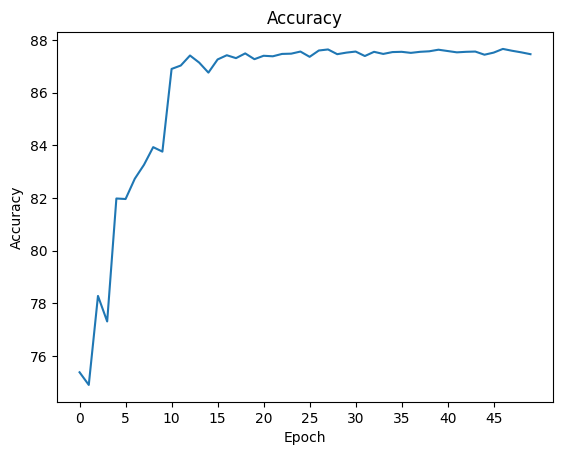

In [20]:
plt.plot(acc_list)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(0,50,5))
plt.ylabel('Accuracy')
plt.show()

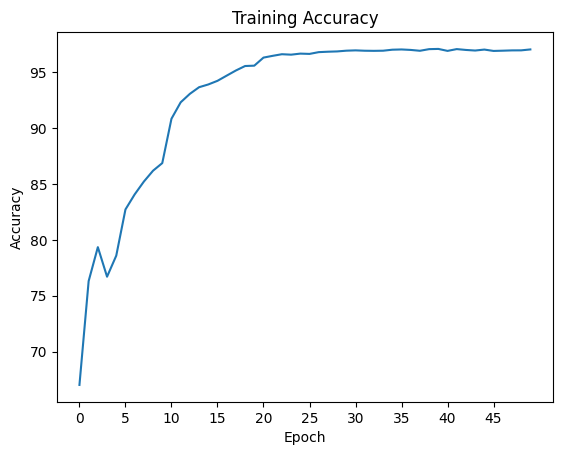

In [21]:
plt.plot(train_acc_list)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(0,50,5))
plt.ylabel('Accuracy')
plt.show()

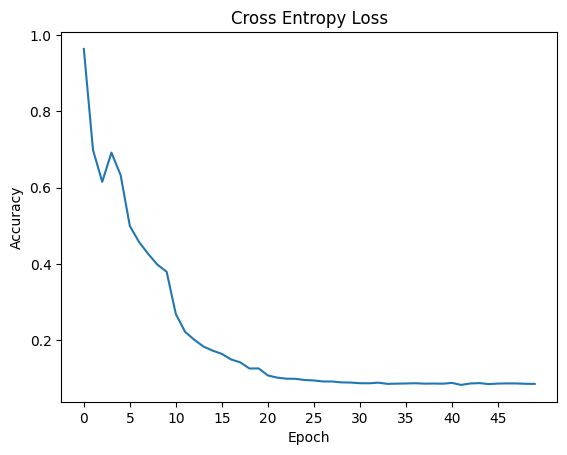

In [22]:
plt.plot(loss_list)
plt.title('Cross Entropy Loss')
plt.xlabel('Epoch')
plt.xticks(np.arange(0,50,5))
plt.ylabel('Accuracy')
plt.show()